In [1]:
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
import duckdb

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

### What can be the major seasonal changes that we can observe in accordance with Mexico’s climate?

In [2]:
stations_daily_csv = Path('./data/stations_daily.csv')
stations_hourly_csv = Path('./data/stations_hourly.csv')
stations_rsinaica_csv = Path('./data/stations_rsinaica.csv')
precipitation_xls = Path('./Precipitacion')

In [3]:
df_daily = pd.read_csv(stations_daily_csv)
df_hourly = pd.read_csv(stations_hourly_csv)
df_rsinaica = pd.read_csv(stations_rsinaica_csv)

In [4]:
gdl_station_ids = df_rsinaica.loc[df_rsinaica['network_name'] == 'Guadalajara']['station_id'].to_list()

In [5]:
df_daily_gdl = df_daily\
    .where(df_daily['station_id'].isin(gdl_station_ids))\
        .dropna(how='all')

In [6]:
non_null_cols = [
    'datetime', 'station_id', 'PM2.5',
    'PM10', 'NOx', 'O3',
    'CO', 'HR', 'NO',
    'NO2', 'TMP', 'PP',
    'RS', 'TMPI'
    ]

### Obtaining dimension tables from csv file rsinaica

In [7]:
station_dim_table = duckdb.sql("""
    SELECT
       station_id,
       station_code,
       station_name,
       network_name,
       lat,
       lon
    FROM df_rsinaica
""").to_df()

### Mapping weather seasons to air quality data based on datetime

In [8]:
df_daily['datetime'] = pd.to_datetime(df_daily['datetime'])

In [9]:
df_hourly['datetime'] = pd.to_datetime(df_daily['datetime'])

In [10]:
df_daily_w_seasons = duckdb.sql("""
    SELECT
        *,
        CASE
            WHEN datetime BETWEEN DATE_TRUNC('year', datetime)
                            AND DATE_TRUNC('year', datetime) + INTERVAL '2 months 18 days'
            THEN 'WINTER'

            WHEN datetime BETWEEN DATE_TRUNC('year', datetime) + INTERVAL '2 months 19 days'
                            AND DATE_TRUNC('year', datetime) + INTERVAL '5 months 19 days'
            THEN 'SPRING'

            WHEN datetime BETWEEN DATE_TRUNC('year', datetime) + INTERVAL '5 months 20 days'
                            AND DATE_TRUNC('year', datetime) + INTERVAL '8 months 21 days'
            THEN 'SUMMER'

            WHEN datetime BETWEEN DATE_TRUNC('year', datetime) + INTERVAL '8 months 22 days'
                            AND DATE_TRUNC('year', datetime) + INTERVAL '11 months 19 days'
            THEN 'FALL'

            WHEN datetime BETWEEN DATE_TRUNC('year', datetime) + INTERVAL '11 months 20 days'
                            AND DATE_TRUNC('year', datetime) + INTERVAL '11 months 31 days'
            THEN 'WINTER'

            ELSE NULL
        END AS season
    FROM df_daily;
""").to_df()


### Loading precipitation historical data

Comportamiento de la lluvia promedio mensual a nievel estatal y nacional desde 1985 a la fecha medida a través de estaciones convencionales y automáticas

Ultima modificacion del archivo: `2025-04-29T00:00:00Z`

In [11]:
p = Path('./Precipitacion/Precipitacion/')

In [12]:
# Read every excel file, take the year of the file name and put it as new value in column year

map_eng_spa_cols = {
    'ENTIDAD': 'State',
    'ENE': 'January',
    'FEB': 'February',
    'MAR': 'March',
    'ABR': 'April',
    'MAY': 'May',
    'JUN': 'June',
    'JUL': 'July',
    'AGO': 'August',
    'SEP': 'September',
    'OCT': 'October',
    'NOV': 'November',
    'DIC': 'December',
    'ANUAL': 'Yearly'
}

df_rain = pd.DataFrame()

for file in p.glob('*'):
    current_file_year = str(file).split('/')[2][:4]
    current_file_df = pd.read_excel(file, header=1).iloc[:-1]
    current_file_df['YEAR'] = current_file_year
    df_rain = pd.concat([df_rain, current_file_df])

df_rain.rename(columns=map_eng_spa_cols, inplace=True)

df_rain['State'] = df_rain['State'].apply(lambda x: str(x).upper()) 

#### Enriching station datasets with information about the stations: name, code, etc.

In [13]:
df_daily_enriched = duckdb.sql("""
   SELECT 
      daily.*,
      stations.station_code,
      stations.station_name,
      stations.network_name,
      stations.lat,
      stations.lon
   FROM df_daily_w_seasons daily
   JOIN station_dim_table stations
      ON stations.station_id = daily.station_id;
""").to_df()

#### Produce long format for precipitation datasets to ease join with daily and hourly datasets

In [14]:
df_rain_value_cols = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September','October', 'November', 'December']
df_rain_id_cols = ['State', 'YEAR']

In [15]:
df_rain_long = pd.melt(df_rain, id_vars=df_rain_id_cols,  value_vars=df_rain_value_cols)
df_rain_long.rename(columns={'variable': 'Month', 'value':'Precipitation'}, inplace=True)
df_rain_long['Year'] = df_rain_long['YEAR'].astype('int16')

#### Filtering by cities of interest

In [16]:
df_gdl = duckdb.sql("""
   SELECT
      daily.*,
      rain.State,
      rain.Precipitation
   FROM df_daily_enriched daily
   JOIN df_rain_long rain
      ON monthname(daily.datetime) = rain.Month
   WHERE 
      daily.network_name = 'Guadalajara' AND
      rain.State = 'JALISCO' 
""").to_df()

In [17]:
df_mty = duckdb.sql("""
   SELECT
      daily.*,
      rain.State,
      rain.Precipitation
   FROM df_daily_enriched daily
   JOIN df_rain_long rain
      ON monthname(daily.datetime) = rain.Month
   WHERE 
      daily.network_name = 'Monterrey' AND
      rain.State = 'NUEVO LEÓN' 
""").to_df()

In [18]:
df_pue = duckdb.sql("""
   SELECT
      daily.*,
      rain.State,
      rain.Precipitation
   FROM df_daily_enriched daily
   JOIN df_rain_long rain
      ON monthname(daily.datetime) = rain.Month
   WHERE 
      daily.network_name = 'Puebla' AND
      rain.State = 'PUEBLA' 
""").to_df()

In [19]:
df_cdmx = duckdb.sql("""
   SELECT
      daily.*,
      rain.State,
      rain.Precipitation
   FROM df_daily_enriched daily
   JOIN df_rain_long rain
      ON monthname(daily.datetime) = rain.Month
   WHERE 
      daily.network_name = 'Valle de México' AND
      rain.State = 'CIUDAD DE MÉXICO' 
""").to_df()

#### Calculating monthly median and mean for pollutants

In [20]:
df_gdl_monthly = duckdb.sql("""
    SELECT
       State,
       network_name,
       YEAR(datetime) AS Year,
       MONTHNAME(datetime) AS Month,
       LOWER(Season) AS Season,
       MEAN("TMP") AS avg_tmp,
       MEDIAN("TMP") AS median_tmp,
       MEAN("PM2.5") AS avg_pm2_5,
       MEDIAN("PM2.5") AS median_pm2_5,
       MEAN("PM10") AS avg_pm10,
       MEDIAN("PM10") AS median_pm10,
       MEAN("O3") AS avg_o3,
       MEDIAN("O3") AS median_o3,
       MEAN("NOx") AS avg_nox,
       MEDIAN("NOx") AS median_nox,
       MEAN("NO") AS avg_no,
       MEDIAN("NO") AS median_no,
       MEAN("NO2") AS avg_no2,
       MEDIAN("NO2") AS median_no2,
       MEAN("CO") AS avg_co,
       MEDIAN("CO") AS median_co,
       MEAN("PP") AS avg_pp,
       MEDIAN("PP") AS median_pp
    FROM df_gdl
    GROUP BY State, network_name, Year, Month, Season
""").to_df()

In [21]:
df_mty_monthly = duckdb.sql("""
    SELECT
       State,
       network_name,
       YEAR(datetime) AS Year,
       MONTHNAME(datetime) AS Month,
       LOWER(Season) AS Season,
       MEAN("TMP") AS avg_tmp,
       MEDIAN("TMP") AS median_tmp,
       MEAN("PM2.5") AS avg_pm2_5,
       MEDIAN("PM2.5") AS median_pm2_5,
       MEAN("PM10") AS avg_pm10,
       MEDIAN("PM10") AS median_pm10,
       MEAN("O3") AS avg_o3,
       MEDIAN("O3") AS median_o3,
       MEAN("NOx") AS avg_nox,
       MEDIAN("NOx") AS median_nox,
       MEAN("NO") AS avg_no,
       MEDIAN("NO") AS median_no,
       MEAN("NO2") AS avg_no2,
       MEDIAN("NO2") AS median_no2,
       MEAN("CO") AS avg_co,
       MEDIAN("CO") AS median_co,
       MEAN("PP") AS avg_pp,
       MEDIAN("PP") AS median_pp
    FROM df_mty
    GROUP BY State, network_name, Year, Month, Season
""").to_df()

In [22]:
df_pue_monthly = duckdb.sql("""
    SELECT
       State,
       network_name,
       YEAR(datetime) AS Year,
       MONTHNAME(datetime) AS Month,
       LOWER(Season) AS Season,
       MEAN("TMP") AS avg_tmp,
       MEDIAN("TMP") AS median_tmp,
       MEAN("PM2.5") AS avg_pm2_5,
       MEDIAN("PM2.5") AS median_pm2_5,
       MEAN("PM10") AS avg_pm10,
       MEDIAN("PM10") AS median_pm10,
       MEAN("O3") AS avg_o3,
       MEDIAN("O3") AS median_o3,
       MEAN("NOx") AS avg_nox,
       MEDIAN("NOx") AS median_nox,
       MEAN("NO") AS avg_no,
       MEDIAN("NO") AS median_no,
       MEAN("NO2") AS avg_no2,
       MEDIAN("NO2") AS median_no2,
       MEAN("CO") AS avg_co,
       MEDIAN("CO") AS median_co,
       MEAN("PP") AS avg_pp,
       MEDIAN("PP") AS median_pp
    FROM df_pue
    GROUP BY State, network_name, Year, Month, Season
""").to_df()

In [23]:
df_cdmx_monthly = duckdb.sql("""
    SELECT
       State,
       network_name,
       YEAR(datetime) AS Year,
       MONTHNAME(datetime) AS Month,
       LOWER(Season) AS Season,
       MEAN("TMP") AS avg_tmp,
       MEDIAN("TMP") AS median_tmp,
       MEAN("PM2.5") AS avg_pm2_5,
       MEDIAN("PM2.5") AS median_pm2_5,
       MEAN("PM10") AS avg_pm10,
       MEDIAN("PM10") AS median_pm10,
       MEAN("O3") AS avg_o3,
       MEDIAN("O3") AS median_o3,
       MEAN("NOx") AS avg_nox,
       MEDIAN("NOx") AS median_nox,
       MEAN("NO") AS avg_no,
       MEDIAN("NO") AS median_no,
       MEAN("NO2") AS avg_no2,
       MEDIAN("NO2") AS median_no2,
       MEAN("CO") AS avg_co,
       MEDIAN("CO") AS median_co,
       MEAN("PP") AS avg_pp,
       MEDIAN("PP") AS median_pp
    FROM df_cdmx
    GROUP BY State, network_name, Year, Month, Season
""").to_df()

#### Enriching monthly pollution averages and median with monthly precipitation averages from CONAGUA dataset

In [ ]:
df_gdl_final = duckdb.sql("""
   SELECT
      monthly.*,
      rain.State,
      rain.Precipitation
   FROM df_gdl_monthly monthly
   JOIN df_rain_long rain
      ON monthly.Year = rain.Year
      AND monthly.Month = rain.Month
      AND monthly.State = rain.State
""").to_df()

# Unbalanced seasons were detected, this is the fix:
    
min_count = df_gdl_final['Season'].value_counts().min()
df_gdl_final = df_gdl_final.groupby('Season', group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42))

In [ ]:
df_mty_final = duckdb.sql("""
   SELECT
      monthly.*,
      rain.State,
      rain.Precipitation
   FROM df_mty_monthly monthly
   JOIN df_rain_long rain
      ON monthly.Year = rain.Year
      AND monthly.Month = rain.Month
      AND monthly.State = rain.State
""").to_df()

min_count = df_mty_final['Season'].value_counts().min()
df_mty_final = df_mty_final.groupby('Season', group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42))

In [ ]:
df_pue_final = duckdb.sql("""
   SELECT
      monthly.*,
      rain.State,
      rain.Precipitation
   FROM df_pue_monthly monthly
   JOIN df_rain_long rain
      ON monthly.Year = rain.Year
      AND monthly.Month = rain.Month
      AND monthly.State = rain.State
""").to_df()

min_count = df_pue_final['Season'].value_counts().min()
df_pue_final = df_pue_final.groupby('Season', group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42))

In [ ]:
df_cdmx_final = duckdb.sql("""
   SELECT
      monthly.*,
      rain.State,
      rain.Precipitation
   FROM df_cdmx_monthly monthly
   JOIN df_rain_long rain
      ON monthly.Year = rain.Year
      AND monthly.Month = rain.Month
      AND monthly.State = rain.State
""").to_df()

min_count = df_cdmx_final['Season'].value_counts().min()
df_cdmx_final = df_cdmx_final.groupby('Season', group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42))

#### Kendall Tau correlation coefficient results

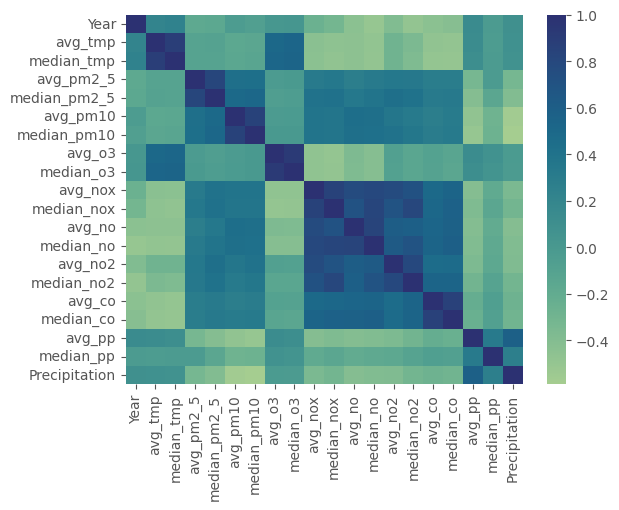

In [28]:
corr_gdl = df_gdl_final.select_dtypes(['float', 'int']).corr('kendall')
sns.heatmap(corr_gdl, cmap='crest');

In [65]:
corr_gdl['Precipitation'].sort_values()

median_pm10     -0.588109
avg_pm10        -0.565320
avg_no          -0.404563
median_pm2_5    -0.391563
median_no       -0.383836
avg_no2         -0.378504
avg_nox         -0.351671
avg_pm2_5       -0.324744
median_no2      -0.307927
median_nox      -0.302953
median_co       -0.292065
avg_co          -0.277394
median_o3       -0.024071
avg_o3          -0.021991
median_tmp       0.072279
avg_tmp          0.083814
Year             0.091221
median_pp        0.272998
avg_pp           0.583508
Precipitation    1.000000
Name: Precipitation, dtype: float64

As expected `median_pp` and `avg_pp` have the strongest correlation with `Precipitation` (because they are precipitation columns as well, but from air quality monitoring station measurements, not from CONAGUA dataset). This indicates that 1) switching from Pearon to Kendall correlation did not produce a negative effect, and 2) the correlation between the other measurements is not linear. We can also observe that PM10 and PM2.5 measurements have a strong negative correlation with the precipitation measurements. 

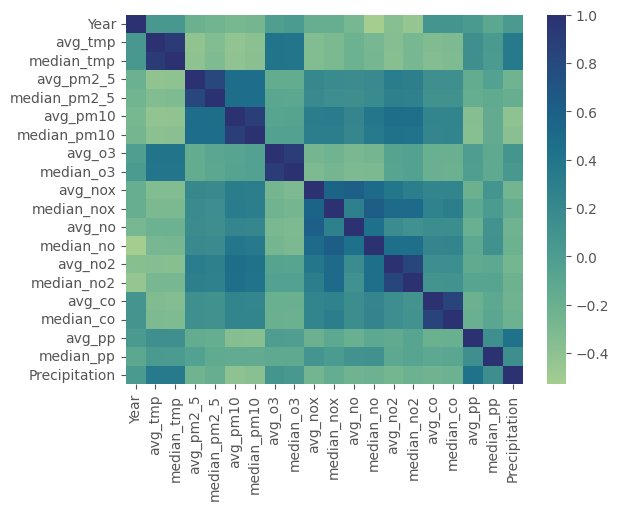

In [29]:
corr_mty = df_mty_final.select_dtypes(['float', 'int']).corr('kendall')
sns.heatmap(corr_mty, cmap='crest');

In [66]:
corr_mty['Precipitation'].sort_values()

avg_pm10        -0.399039
median_pm10     -0.383158
avg_no2         -0.264151
avg_nox         -0.257106
avg_pm2_5       -0.239883
avg_co          -0.232259
avg_no          -0.231899
median_no       -0.220386
median_no2      -0.217623
median_co       -0.215232
median_pm2_5    -0.188265
median_nox      -0.167561
Year             0.021919
median_o3        0.043755
avg_o3           0.070065
median_pp        0.143226
median_tmp       0.351476
avg_tmp          0.354157
avg_pp           0.430622
Precipitation    1.000000
Name: Precipitation, dtype: float64

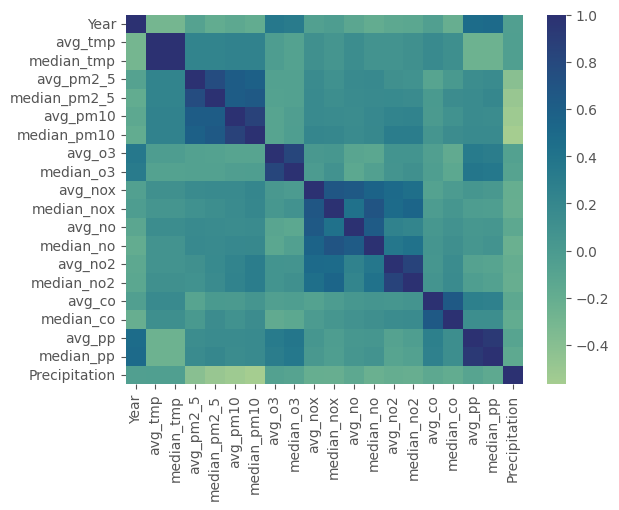

In [30]:
corr_pue = df_pue_final.select_dtypes(['float', 'int']).corr('kendall')
sns.heatmap(corr_pue, cmap='crest');

In [67]:
corr_pue['Precipitation'].sort_values()

median_pm10     -0.565969
avg_pm10        -0.524539
median_pm2_5    -0.488541
avg_pm2_5       -0.410195
median_no       -0.231758
median_nox      -0.213353
median_no2      -0.211243
avg_nox         -0.208294
avg_no2         -0.204785
median_co       -0.181762
median_pp       -0.155714
avg_co          -0.149438
avg_no          -0.147556
avg_pp          -0.107179
median_o3       -0.089417
avg_o3          -0.067342
Year            -0.053492
avg_tmp         -0.046335
median_tmp      -0.046335
Precipitation    1.000000
Name: Precipitation, dtype: float64

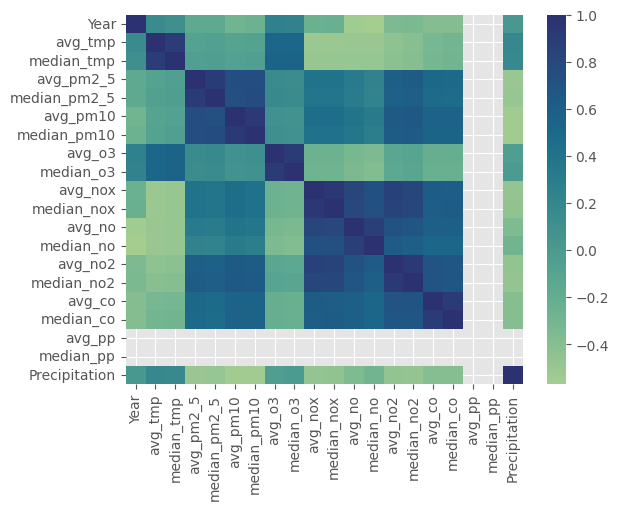

In [31]:
corr_cdmx = df_cdmx_final.select_dtypes(['float', 'int']).corr('kendall')
sns.heatmap(corr_cdmx, cmap='crest');

In [68]:
corr_cdmx['Precipitation'].sort_values()

median_pm10     -0.550990
avg_pm10        -0.549192
avg_pm2_5       -0.503033
median_pm2_5    -0.488445
median_no2      -0.470390
avg_nox         -0.468089
avg_no2         -0.462082
median_nox      -0.458860
avg_co          -0.403219
median_co       -0.398080
avg_no          -0.358433
median_no       -0.284724
avg_o3          -0.040506
median_o3       -0.014015
Year             0.023541
median_tmp       0.175854
avg_tmp          0.181493
Precipitation    1.000000
avg_pp                NaN
median_pp             NaN
Name: Precipitation, dtype: float64

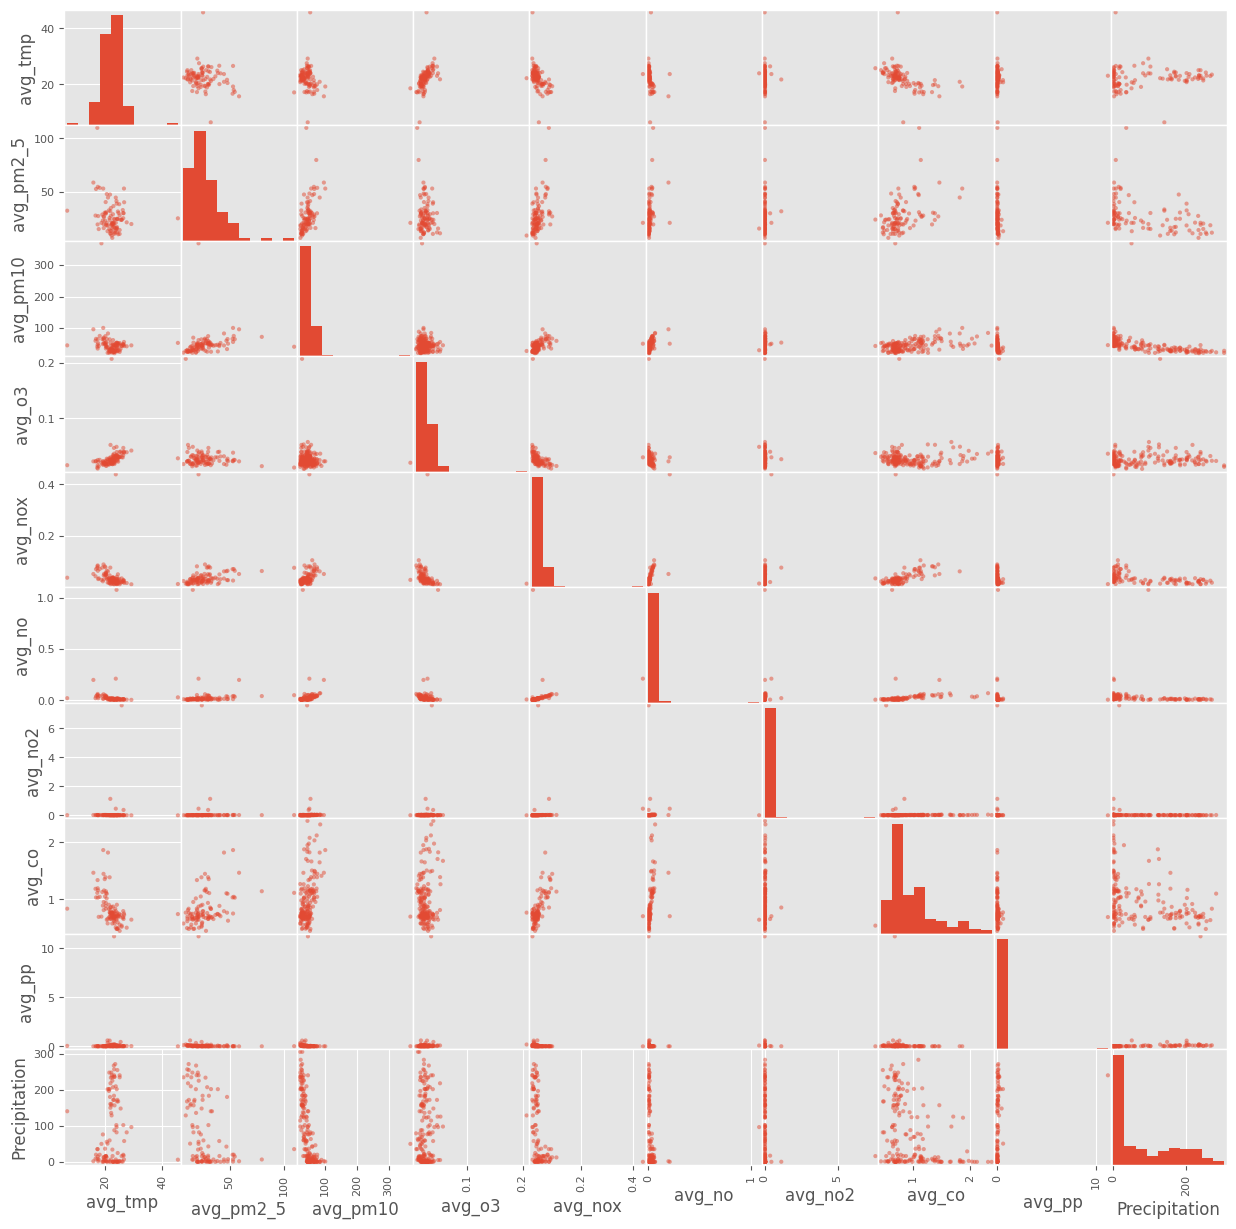

In [32]:
from pandas.plotting import scatter_matrix

mean_values_cols = df_gdl_final.columns.str.contains(pat='^[avg_]', regex=True)
mean_values_cols = [*df_gdl_final.columns[mean_values_cols]]
mean_values_cols.append('Precipitation')

scatter_matrix(
    df_gdl_final[mean_values_cols], 
    figsize=(15, 15));

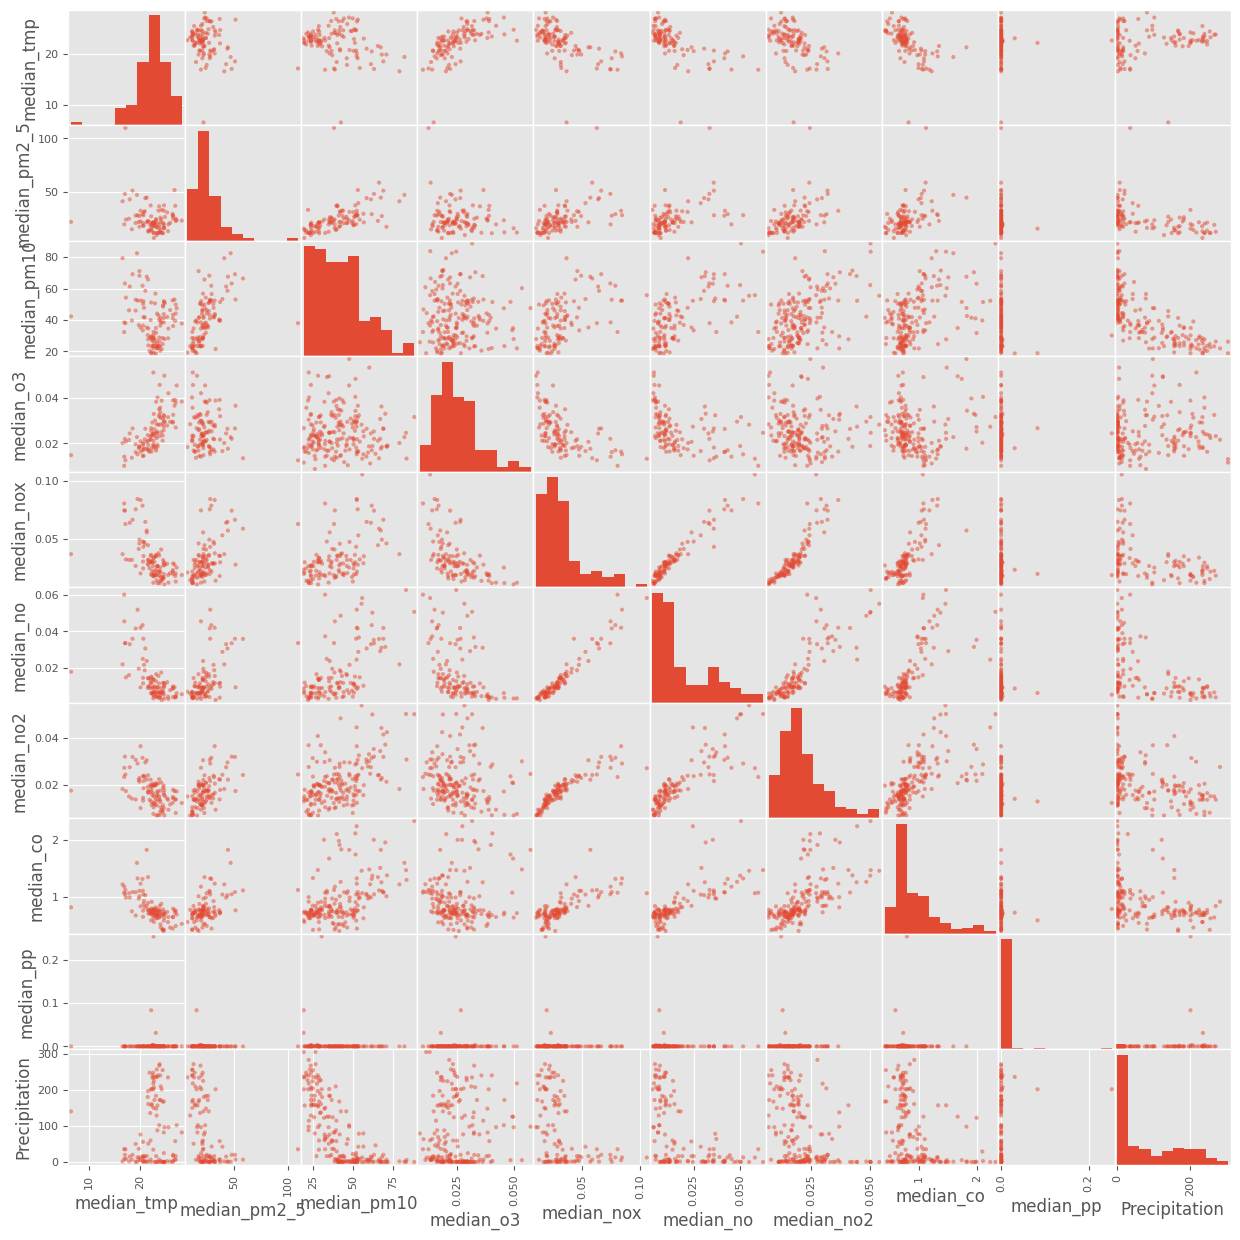

In [33]:
median_values_cols = df_gdl_final.columns.str.contains(pat='^median_', regex=True)
median_values_cols = [*df_gdl_final.columns[median_values_cols]]
median_values_cols.append('Precipitation')

scatter_matrix(
    df_gdl_final[median_values_cols], 
    figsize=(15, 15));

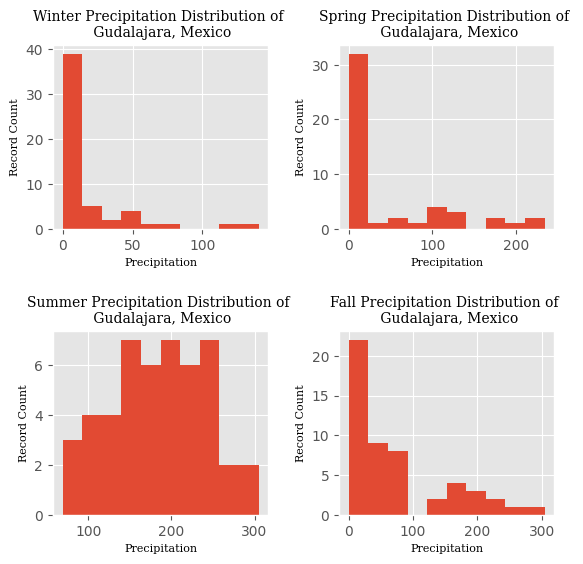

In [54]:
plt.figure(figsize=(6, 6))

axis_font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 8,
    }

title_font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 10,
    }

for season in enumerate(df_gdl_final['Season'].unique(), start=1):
    plt.tight_layout(pad=2)
    plt.subplot(2, 2, season[0])
    plt.hist(df_gdl_final['Precipitation'].loc[(df_gdl_final['Season'] == season[1])])
    plt.xlabel('Precipitation',fontdict=axis_font)
    plt.ylabel('Record Count',fontdict=axis_font)
    plt.title(f'{season[1].capitalize()} Precipitation Distribution of \n Gudalajara, Mexico', fontdict=title_font)

According to García Amaro de Miranda, Enriqueta. (2003), “On the rest of the Pacific slopes, precipitation occurs essentially in summer and part of autumn. The first suggests, as Sands suggests, that the entry of the tongue of moisture into the interior of the country from the Pacific side may be feasible, and the second relates the greater frequency of tropical cyclones originating in the Pacific Ocean with the increase in precipitation in September.”, this applies to Guadalajara city, also known as the Pacific’s pearl, we can demonstrate this and also demonstrate the effects of rainfall on PM levels in the following graphs:

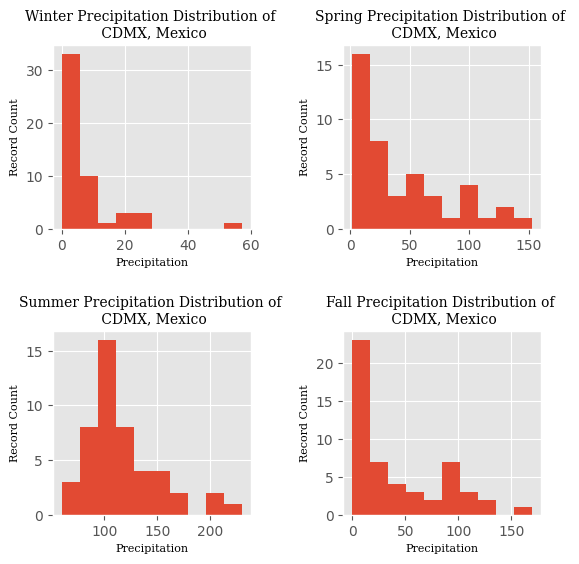

In [56]:
plt.figure(figsize=(6, 6))

axis_font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 8,
    }

title_font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 10,
    }

for season in enumerate(df_cdmx_final['Season'].unique(), start=1):
    plt.tight_layout(pad=2)
    plt.subplot(2, 2, season[0])
    plt.hist(df_cdmx_final['Precipitation'].loc[(df_cdmx_final['Season'] == season[1])])
    plt.xlabel('Precipitation',fontdict=axis_font)
    plt.ylabel('Record Count',fontdict=axis_font)
    plt.title(f'{season[1].capitalize()} Precipitation Distribution of \n CDMX, Mexico', fontdict=title_font)

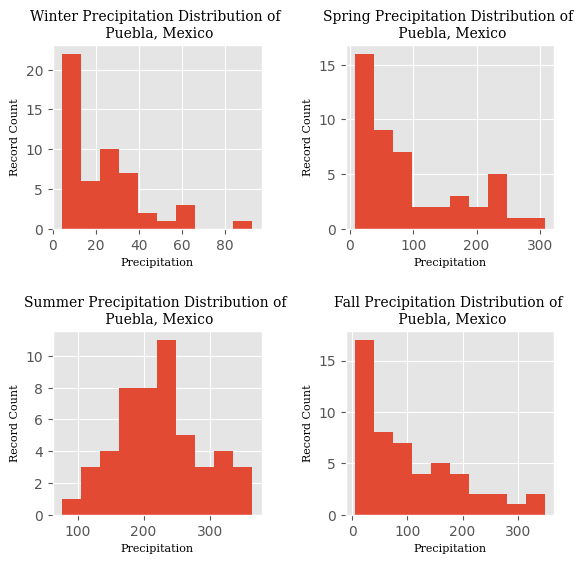

In [57]:
plt.figure(figsize=(6, 6))

axis_font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 8,
    }

title_font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 10,
    }

for season in enumerate(df_pue_final['Season'].unique(), start=1):
    plt.tight_layout(pad=2)
    plt.subplot(2, 2, season[0])
    plt.hist(df_pue_final['Precipitation'].loc[(df_pue_final['Season'] == season[1])])
    plt.xlabel('Precipitation',fontdict=axis_font)
    plt.ylabel('Record Count',fontdict=axis_font)
    plt.title(f'{season[1].capitalize()} Precipitation Distribution of \n Puebla, Mexico', fontdict=title_font)

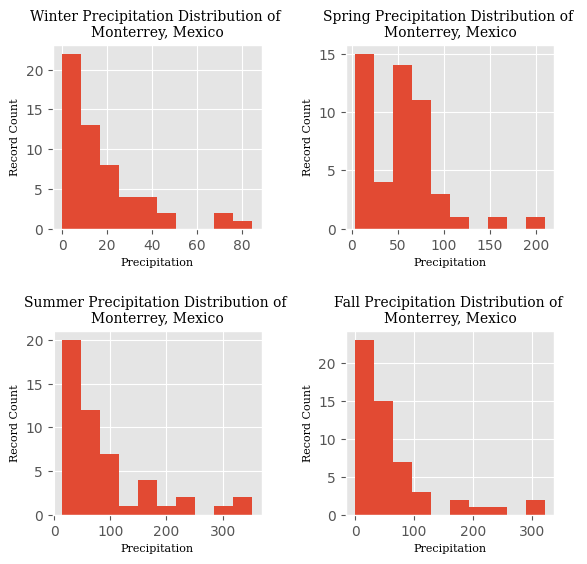

In [58]:
plt.figure(figsize=(6, 6))

axis_font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 8,
    }

title_font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 10,
    }

for season in enumerate(df_mty_final['Season'].unique(), start=1):
    plt.tight_layout(pad=2)
    plt.subplot(2, 2, season[0])
    plt.hist(df_mty_final['Precipitation'].loc[(df_mty_final['Season'] == season[1])])
    plt.xlabel('Precipitation',fontdict=axis_font)
    plt.ylabel('Record Count',fontdict=axis_font)
    plt.title(f'{season[1].capitalize()} Precipitation Distribution of \nMonterrey, Mexico', fontdict=title_font)

In [38]:
# Calculate the median value of seasonal precipitation

seasonal_median_gdl = duckdb.sql("""
    SELECT
       season,
       MEDIAN(Precipitation) AS seasonal_precipitation_median,
       MEDIAN(median_pm10) AS seasonal_pm10_median,
       MEDIAN(median_pm2_5) AS seasonal_pm2_5_median,
       STDDEV_SAMP(Precipitation) AS seasonal_precipitation_stddev_samp,
       STDDEV_SAMP(median_pm10) AS seasonal_pm10_stddev_samp,
       STDDEV_SAMP(median_pm2_5) AS seasonal_pm2_5_stddev_samp
    FROM df_gdl_final
    GROUP BY season;
""").to_df()

In [39]:
# Calculate the median value of seasonal precipitation

seasonal_median_pue = duckdb.sql("""
    SELECT
       season,
       MEDIAN(Precipitation) AS seasonal_precipitation_median,
       MEDIAN(median_pm10) AS seasonal_pm10_median,
       MEDIAN(median_pm2_5) AS seasonal_pm2_5_median,
       STDDEV_SAMP(Precipitation) AS seasonal_precipitation_stddev_samp,
       STDDEV_SAMP(median_pm10) AS seasonal_pm10_stddev_samp,
       STDDEV_SAMP(median_pm2_5) AS seasonal_pm2_5_stddev_samp
    FROM df_pue_final
    GROUP BY season;
""").to_df()

In [40]:
# Calculate the median value of seasonal precipitation

seasonal_median_mty = duckdb.sql("""
    SELECT
       season,
       MEDIAN(Precipitation) AS seasonal_precipitation_median,
       MEDIAN(median_pm10) AS seasonal_pm10_median,
       MEDIAN(median_pm2_5) AS seasonal_pm2_5_median,
       STDDEV_SAMP(Precipitation) AS seasonal_precipitation_stddev_samp,
       STDDEV_SAMP(median_pm10) AS seasonal_pm10_stddev_samp,
       STDDEV_SAMP(median_pm2_5) AS seasonal_pm2_5_stddev_samp
    FROM df_mty_final
    GROUP BY season;
""").to_df()

In [41]:
# Calculate the median value of seasonal precipitation

seasonal_median_cdmx = duckdb.sql("""
    SELECT
       season,
       MEDIAN(Precipitation) AS seasonal_precipitation_median,
       MEDIAN(median_pm10) AS seasonal_pm10_median,
       MEDIAN(median_pm2_5) AS seasonal_pm2_5_median,
       STDDEV_SAMP(Precipitation) AS seasonal_precipitation_stddev_samp,
       STDDEV_SAMP(median_pm10) AS seasonal_pm10_stddev_samp,
       STDDEV_SAMP(median_pm2_5) AS seasonal_pm2_5_stddev_samp
    FROM df_cdmx_final
    GROUP BY season;
""").to_df()

In [42]:
seasonal_median_cols = [
    'Season', 'seasonal_precipitation_median', 
    'seasonal_pm10_median', 'seasonal_pm2_5_median'
    ]

seasonal_stddev_cols = [
    'Season', 'seasonal_precipitation_stddev_samp', 
    'seasonal_pm10_stddev_samp', 'seasonal_pm2_5_stddev_samp'
    ]

seasonal_median_gdl_long = pd.melt(
    frame=seasonal_median_gdl[seasonal_median_cols], 
    id_vars='Season', 
    value_vars=seasonal_median_cols
    )

seasonal_stddev_gdl_long = pd.melt(
    frame=seasonal_median_gdl[seasonal_stddev_cols], 
    id_vars='Season', 
    value_vars=seasonal_stddev_cols
    )

seasonal_median_gdl_long.rename(
    columns={'variable': 'measurement_name', 'value': 'median'}, 
    inplace=True
    )

seasonal_stddev_gdl_long.rename(
    columns={'variable': 'stddev_name', 'value': 'stddev'}, 
    inplace=True
    )

seasonal_median_gdl_long = pd\
    .concat([seasonal_median_gdl_long, seasonal_stddev_gdl_long], axis=1)\
        .iloc[:,1:]
        
seasonal_median_gdl_long['Season'] = seasonal_median_gdl_long['Season'].apply(lambda x: str(x).capitalize())

In [43]:
seasonal_median_pue_long = pd.melt(
    frame=seasonal_median_pue[seasonal_median_cols], 
    id_vars='Season', 
    value_vars=seasonal_median_cols
    )

seasonal_stddev_pue_long = pd.melt(
    frame=seasonal_median_pue[seasonal_stddev_cols], 
    id_vars='Season', 
    value_vars=seasonal_stddev_cols
    )

seasonal_median_pue_long.rename(
    columns={'variable': 'measurement_name', 'value': 'median'}, 
    inplace=True
    )

seasonal_stddev_pue_long.rename(
    columns={'variable': 'stddev_name', 'value': 'stddev'}, 
    inplace=True
    )

seasonal_median_pue_long = pd\
    .concat([seasonal_median_pue_long, seasonal_stddev_pue_long], axis=1)\
        .iloc[:,1:]
        
seasonal_median_pue_long['Season'] = seasonal_median_pue_long['Season'].apply(lambda x: str(x).capitalize())

In [44]:
seasonal_median_mty_long = pd.melt(
    frame=seasonal_median_mty[seasonal_median_cols], 
    id_vars='Season', 
    value_vars=seasonal_median_cols
    )

seasonal_stddev_mty_long = pd.melt(
    frame=seasonal_median_pue[seasonal_stddev_cols], 
    id_vars='Season', 
    value_vars=seasonal_stddev_cols
    )

seasonal_median_mty_long.rename(
    columns={'variable': 'measurement_name', 'value': 'median'}, 
    inplace=True
    )

seasonal_stddev_mty_long.rename(
    columns={'variable': 'stddev_name', 'value': 'stddev'}, 
    inplace=True
    )

seasonal_median_mty_long = pd\
    .concat([seasonal_median_mty_long, seasonal_stddev_mty_long], axis=1)\
        .iloc[:,1:]
        
seasonal_median_mty_long['Season'] = seasonal_median_mty_long['Season'].apply(lambda x: str(x).capitalize())

In [45]:
seasonal_median_cdmx_long = pd.melt(
    frame=seasonal_median_cdmx[seasonal_median_cols], 
    id_vars='Season', 
    value_vars=seasonal_median_cols
    )

seasonal_stddev_cdmx_long = pd.melt(
    frame=seasonal_median_cdmx[seasonal_stddev_cols], 
    id_vars='Season', 
    value_vars=seasonal_stddev_cols
    )

seasonal_median_cdmx_long.rename(
    columns={'variable': 'measurement_name', 'value': 'median'}, 
    inplace=True
    )

seasonal_stddev_cdmx_long.rename(
    columns={'variable': 'stddev_name', 'value': 'stddev'}, 
    inplace=True
    )

seasonal_median_cdmx_long = pd\
    .concat([seasonal_median_cdmx_long, seasonal_stddev_cdmx_long], axis=1)\
        .iloc[:,1:]
        
seasonal_median_cdmx_long['Season'] = seasonal_median_cdmx_long['Season'].apply(lambda x: str(x).capitalize())

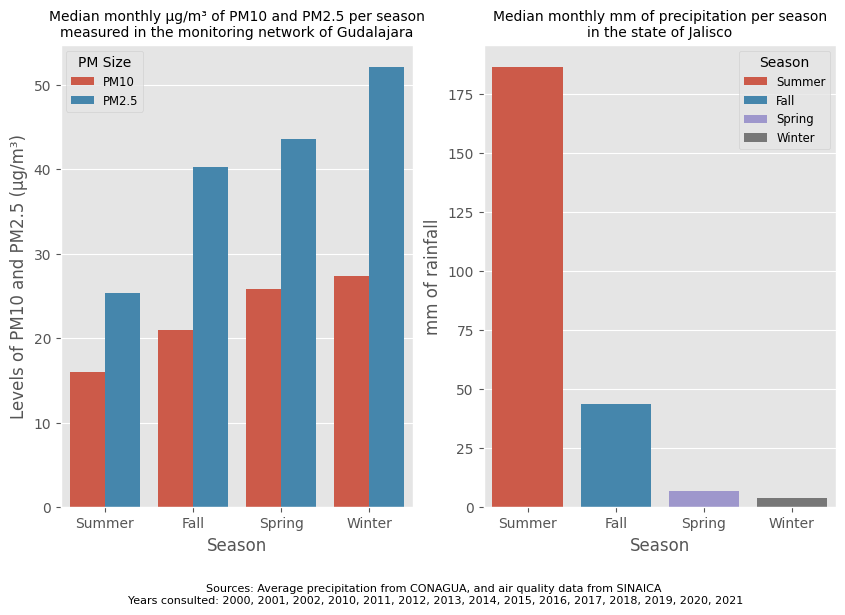

In [59]:
figure, axes = plt.subplots(ncols=2, figsize=(10, 6))
plt.subplots_adjust(hspace = 30)

sns.barplot(
    seasonal_median_gdl_long.iloc[4:]\
        .sort_values(by='median'),
    x='Season',
    y='median',
    hue='measurement_name',
    legend='brief',
    ax=axes[0],
    )

sns.barplot(
    seasonal_median_gdl_long.iloc[:4]\
        .sort_values(by='median', ascending=False),
    x='Season',
    y='median',
    hue='Season',
    legend='brief',
    ax=axes[1]
    )

sns.move_legend(
    axes[0], "upper right",
    bbox_to_anchor=(.25, 1), ncol=1, title='PM Size', frameon=True,
    fontsize='small', labels=['PM10', 'PM2.5']
)

sns.move_legend(
    axes[1], "upper right",
    bbox_to_anchor=(1, 1), ncol=1, title='Season', frameon=True,
    fontsize='small'
)

axes[0].set_title('Median monthly µg/m³ of PM10 and PM2.5 per season\nmeasured in the monitoring network of Gudalajara', fontsize=10)
axes[0].set_ylabel('Levels of PM10 and PM2.5 (µg/m³)')
axes[1].set_title('Median monthly mm of precipitation per season\nin the state of Jalisco', fontsize=10)
axes[1].set_ylabel('mm of rainfall')

plt.figtext(
    0.5, 
    -0.05, 
    f"Sources: Average precipitation from CONAGUA, and air quality data from SINAICA \nYears consulted: {", ".join(map(str, sorted(df_gdl_final['Year'].unique())))}",
    ha="center", 
    fontsize=8
    )
plt.show()


In the case of Guadalajara, we can see that on the left barchart the PM10 and PM2.5 levels are significantly lower in summer compared to Winter, and in the right barchart we can clearly see that summer is the rainiest season, following by fall just as García Amaro de Miranda, Enriqueta. (2003) pointed out in the article Distribution of precipitation in Mexico. This phenomena can be explained by the fact that rain makes the particulate matter stay at ground level, but that doesn’t mean that the city is free of pollution as Greenpeace explains:

"Rain is usually accompanied by wind, which dilutes polluting particles or "sweeps" them away from the city (be careful, it doesn't make them disappear, it just moves them around). What the rain does is fix the particles to the ground, which makes us perceive the environment as cleaner, even if it isn't necessarily so. And if that weren't enough, this rain turns into acid rain, which has serious effects on historical monuments, the soil, etc."

Source: https://www.greenpeace.org/mexico/blog/2300/que-no-te-enganen-la-lluvia-no-limpia-la-contaminacion/

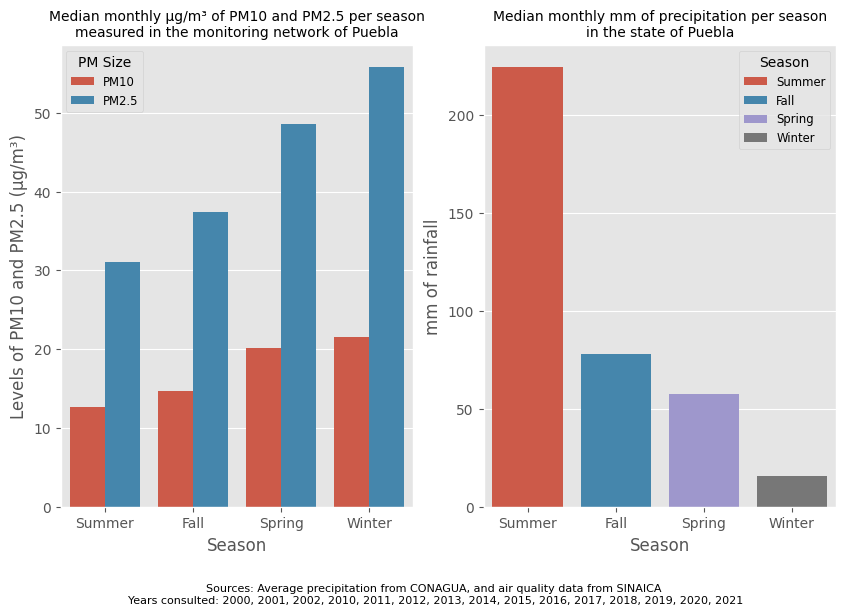

In [60]:
figure, axes = plt.subplots(ncols=2, figsize=(10, 6))
plt.subplots_adjust(hspace = 30)

sns.barplot(
    seasonal_median_pue_long.iloc[4:]\
        .sort_values(by='median'),
    x='Season',
    y='median',
    hue='measurement_name',
    legend='brief',
    ax=axes[0],
    )

sns.barplot(
    seasonal_median_pue_long.iloc[:4]\
        .sort_values(by='median', ascending=False),
    x='Season',
    y='median',
    hue='Season',
    legend='brief',
    ax=axes[1]
    )

sns.move_legend(
    axes[0], "upper right",
    bbox_to_anchor=(.25, 1), ncol=1, title='PM Size', frameon=True,
    fontsize='small', labels=['PM10', 'PM2.5']
)

sns.move_legend(
    axes[1], "upper right",
    bbox_to_anchor=(1, 1), ncol=1, title='Season', frameon=True,
    fontsize='small'
)

axes[0].set_title('Median monthly µg/m³ of PM10 and PM2.5 per season\nmeasured in the monitoring network of Puebla', fontsize=10)
axes[0].set_ylabel('Levels of PM10 and PM2.5 (µg/m³)')
axes[1].set_title('Median monthly mm of precipitation per season\nin the state of Puebla', fontsize=10)
axes[1].set_ylabel('mm of rainfall')

plt.figtext(
    0.5, 
    -0.05, 
    f"Sources: Average precipitation from CONAGUA, and air quality data from SINAICA \nYears consulted: {", ".join(map(str, sorted(df_pue_final['Year'].unique())))}",
    ha="center", 
    fontsize=8
    )
plt.show()


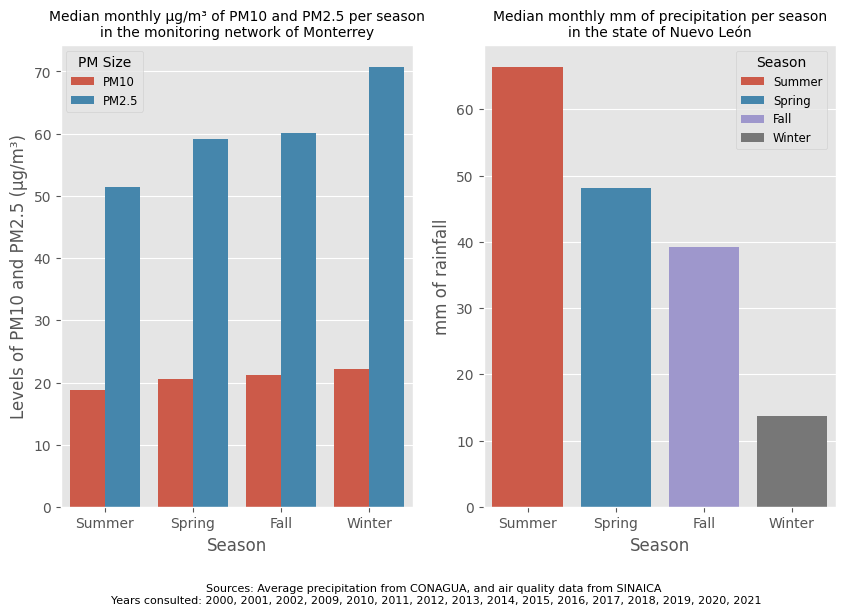

In [61]:
figure, axes = plt.subplots(ncols=2, figsize=(10, 6))
plt.subplots_adjust(hspace = 30)

sns.barplot(
    seasonal_median_mty_long.iloc[4:]\
        .sort_values(by='median'),
    x='Season',
    y='median',
    hue='measurement_name',
    legend='brief',
    ax=axes[0],
    )

sns.barplot(
    seasonal_median_mty_long.iloc[:4]\
        .sort_values(by='median', ascending=False),
    x='Season',
    y='median',
    hue='Season',
    legend='brief',
    ax=axes[1]
    )

sns.move_legend(
    axes[0], "upper right",
    bbox_to_anchor=(.25, 1), ncol=1, title='PM Size', frameon=True,
    fontsize='small', labels=['PM10', 'PM2.5']
)

sns.move_legend(
    axes[1], "upper left",
    bbox_to_anchor=(.7, 1), ncol=1, title='Season', frameon=True,
    fontsize='small'
)

axes[0].set_title('Median monthly µg/m³ of PM10 and PM2.5 per season\nin the monitoring network of Monterrey', fontsize=10)
axes[0].set_ylabel('Levels of PM10 and PM2.5 (µg/m³)')
axes[1].set_title('Median monthly mm of precipitation per season\nin the state of Nuevo León', fontsize=10)
axes[1].set_ylabel('mm of rainfall')

plt.figtext(
    0.5, 
    -0.05, 
    f"Sources: Average precipitation from CONAGUA, and air quality data from SINAICA \nYears consulted: {", ".join(map(str, sorted(df_mty_final['Year'].unique())))}",
    ha="center", 
    fontsize=8
    )
plt.show()


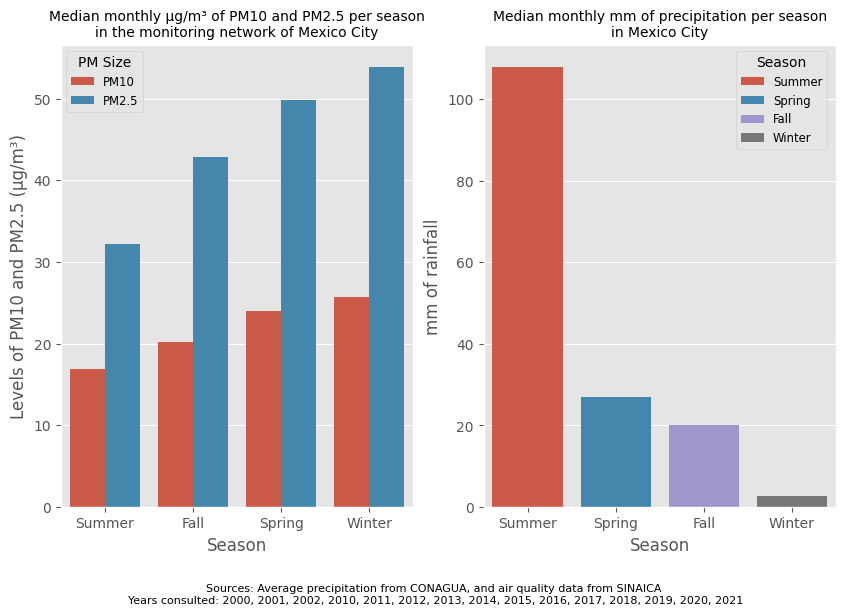

In [62]:
figure, axes = plt.subplots(ncols=2, figsize=(10, 6))
plt.subplots_adjust(hspace = 30)

sns.barplot(
    seasonal_median_cdmx_long.iloc[4:]\
        .sort_values(by='median'),
    x='Season',
    y='median',
    hue='measurement_name',
    legend='brief',
    ax=axes[0],
    )

sns.barplot(
    seasonal_median_cdmx_long.iloc[:4]\
        .sort_values(by='median', ascending=False),
    x='Season',
    y='median',
    hue='Season',
    legend='brief',
    ax=axes[1]
    )

sns.move_legend(
    axes[0], "upper right",
    bbox_to_anchor=(0.25, 1), ncol=1, title='PM Size', frameon=True,
    fontsize='small', labels=['PM10', 'PM2.5']
)

sns.move_legend(
    axes[1], "upper left",
    bbox_to_anchor=(.7, 1), ncol=1, title='Season', frameon=True,
    fontsize='small'
)

axes[0].set_title('Median monthly µg/m³ of PM10 and PM2.5 per season\nin the monitoring network of Mexico City', fontsize=10)
axes[0].set_ylabel('Levels of PM10 and PM2.5 (µg/m³)')
axes[1].set_title('Median monthly mm of precipitation per season\nin Mexico City', fontsize=10)
axes[1].set_ylabel('mm of rainfall')

plt.figtext(
    0.5, 
    -0.05, 
    f"Sources: Average precipitation from CONAGUA, and air quality data from SINAICA \nYears consulted: {", ".join(map(str, sorted(df_cdmx_final['Year'].unique())))}",
    ha="center", 
    fontsize=8
    )
plt.show()
